In [1]:
!pip install emoji transformers

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import re
from collections import Counter, defaultdict
import emoji
from collections import Counter
from tqdm.notebook import tqdm

import random
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer,BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv("/kaggle/input/emotion-detection-from-text/tweet_emotions.csv")
df

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [6]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

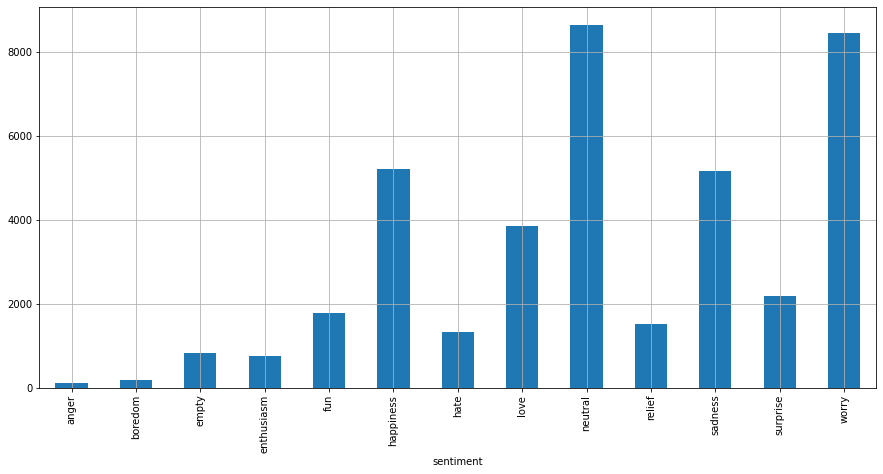

In [7]:
df.groupby('sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)

In [8]:
from sklearn.utils import resample

sent = df.sentiment.unique()

max = 3
target_majority = df[df.sentiment==sent[max]]

#min_class = [0, 2, 5, 7, 8, 10, 11, 12]

for cl in range(13):
    train_minority = df[df.sentiment==sent[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=123)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 
#'''

anger         8638
relief        8638
boredom       8638
happiness     8638
hate          8638
fun           8638
love          8638
surprise      8638
worry         8638
enthusiasm    8638
sadness       8638
empty         8638
neutral       8638
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='sentiment'>

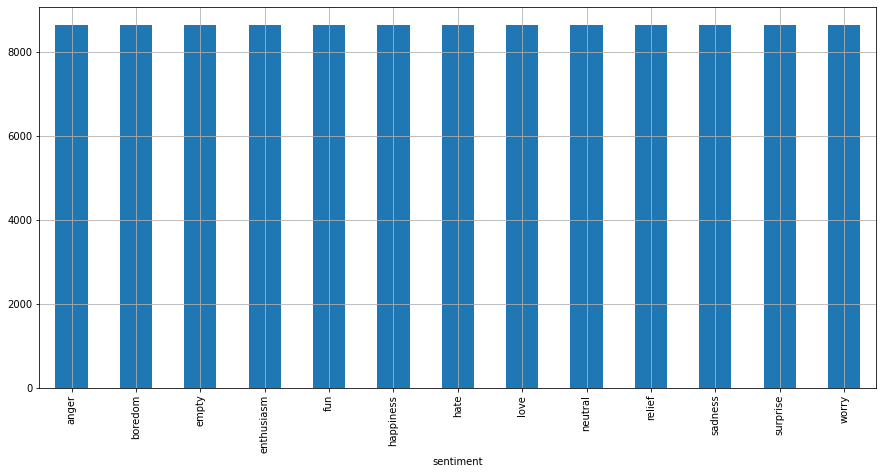

In [9]:
df = train_upsampled.sample(frac=1).reset_index(drop=True)
df.groupby('sentiment')['tweet_id'].count().plot.bar(figsize=(15,7),grid=True)


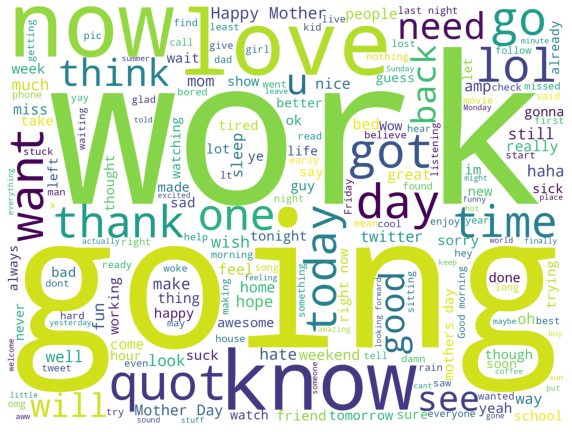

In [10]:
df_cloud = df[df['sentiment']=='neutral'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

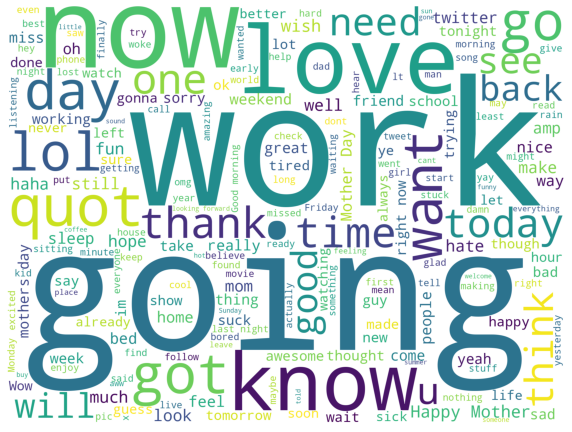

In [11]:
df_cloud = df[df['sentiment']=='happiness'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

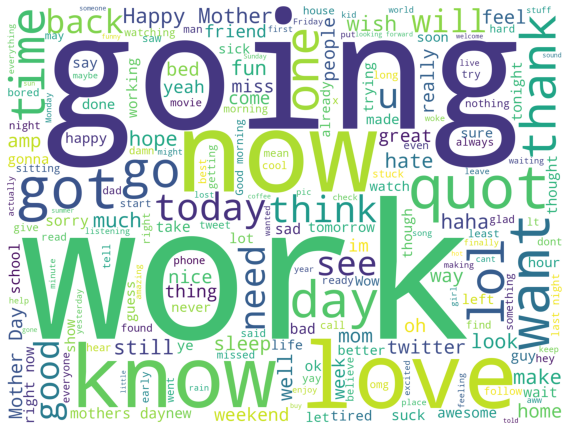

In [12]:
df_cloud = df[df['sentiment']=='worry'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

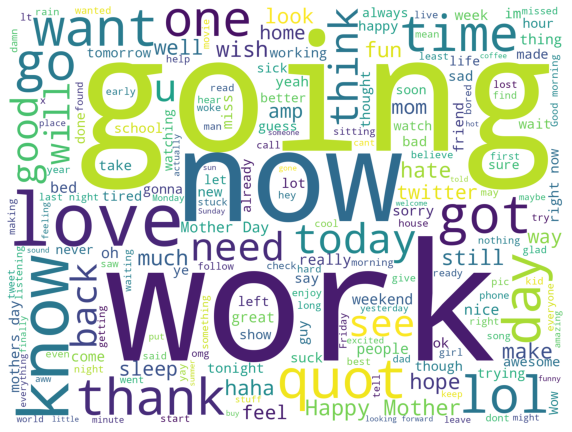

In [13]:
df_cloud = df[df['sentiment']=='sadness'] 
# join tweets to a single string
words = ' '.join(df['content'])
# remove URLs, RTs, and twitter handles
no_urls_no_tags = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2000,
                      height=1500
                     ).generate(no_urls_no_tags)

plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)

In [15]:
sent

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [16]:
label

{'empty': 0,
 'sadness': 1,
 'enthusiasm': 2,
 'neutral': 3,
 'worry': 4,
 'surprise': 5,
 'love': 6,
 'fun': 7,
 'hate': 8,
 'happiness': 9,
 'boredom': 10,
 'relief': 11,
 'anger': 12}

In [17]:
df['label'] = df.sentiment.replace(label)
df.head()


,tweet_id,sentiment,content,label
0,1751069204,enthusiasm,Making pork stir-fry and brown rice for dinner.,2
1,1960538385,boredom,trying to finish my ass-ignment.please god hel...,10
2,1960626140,enthusiasm,fcuk! ayoko na!! I said that in tagalog cuz id...,2
3,1961648166,sadness,"I need to get in a good, hard workout today af...",1
4,1962959571,fun,"On the airport in Philadelphia at the moment, ...",7


In [18]:
from operator import itemgetter  

d = df.label.value_counts()
for key, value in sorted(d.items(), key = itemgetter(0), reverse = False):
    print(key, value)


0 8638
1 8638
2 8638
3 8638
4 8638
5 8638
6 8638
7 8638
8 8638
9 8638
10 8638
11 8638
12 8638


In [19]:
english_stopwords = set(stopwords.words("english"))
english_punctuations = string.punctuation

def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return text

def remove_emails(text):
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", "",  text, flags=re.MULTILINE)
    return text

def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

def remove_stopwords(text):
    filtered_sentence = [w for w in text.split() if not w in english_stopwords]
    return ' '.join(filtered_sentence)

def cleaning_content(line):
    if (isinstance(line, float)):
        return None
    line = line.lower()
    line.replace('\n', ' ')
    line = remove_emails(line)
    line = remove_urls(line)
    line = remove_emoji(line)
    nline = [w if '@' not in w else 'USERID' for w in line.split()]
    line = ' '.join(nline)
    line = line.replace('RT', '').replace('<LF>', '').replace('<br />','').replace('&quot;', '').replace('<url>', '').replace('USERID', '')

    
    # add spaces between punc,
    line = line.translate(str.maketrans({key: " {0} ".format(key) for key in english_punctuations}))

    # then remove punc,
    translator = str.maketrans('', '', english_punctuations)
    line = line.translate(translator)

    line = remove_stopwords(line)
    return line

def hasDigits(s):
    return any( 48 <= ord(char) <= 57  or 1632 <= ord(char) <= 1641 for char in s)


In [20]:
df.content = df.content.apply(cleaning_content)

In [21]:
df

,tweet_id,sentiment,content,label
0,1751069204,enthusiasm,making pork stir fry brown rice dinner,2
1,1960538385,boredom,trying finish ass ignment please god help finish,10
2,1960626140,enthusiasm,fcuk ayoko na said tagalog cuz idk anymore,2
3,1961648166,sadness,need get good hard workout today work feel lik...,1
4,1962959571,fun,airport philadelphia moment waiting plane leav...,7
...,...,...,...,...
112289,1753757761,empty,coding going,0
112290,1694220375,love,lovelies ms rane amp,6
112291,1753647007,love,aww lovely pic,6
112292,1753468987,fun,back sooper dooper extra bharia extra dhumchik...,7


In [22]:
df.drop('tweet_id', inplace=True, axis=1)


In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [24]:
df

,sentiment,content,label
0,enthusiasm,making pork stir fry brown rice dinner,2
1,boredom,trying finish ass ignment please god help finish,10
2,enthusiasm,fcuk ayoko na said tagalog cuz idk anymore,2
3,sadness,need get good hard workout today work feel lik...,1
4,fun,airport philadelphia moment waiting plane leav...,7
...,...,...,...
112289,empty,coding going,0
112290,love,lovelies ms rane amp,6
112291,love,aww lovely pic,6
112292,fun,back sooper dooper extra bharia extra dhumchik...,7


In [25]:
content = ' '.join(list(df.content))
words = content.split(' ')

In [26]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.content)
corpus[:10]


['making',
 'pork',
 'stir',
 'fry',
 'brown',
 'rice',
 'dinner',
 'trying',
 'finish',
 'ass']

In [27]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'day': 8183,
 'good': 6113,
 'get': 5747,
 'like': 5581,
 'go': 5263,
 'work': 5097,
 'going': 4551,
 'got': 4509,
 'today': 4479,
 'im': 4374}

<AxesSubplot:xlabel='sentiment'>

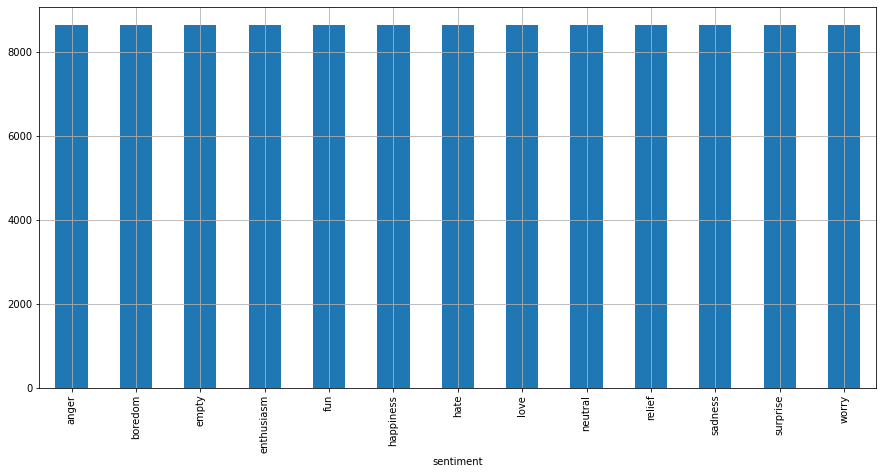

In [28]:
df.groupby('sentiment')['content'].count().plot.bar(figsize=(15,7),grid=True)

In [29]:
max_len = 100

In [30]:
class SentiDataset(Dataset):
    def __init__(self, contents, labels, tokenizer, max_len):
        self.contents = contents
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.contents)
  
    def __getitem__(self, item):
        content = str(self.contents[item])
        label = self.labels[item]
        
        # Tokenizing the texts, while also including special tokens 
        # for start and end of the text, as well as padding
        encoding = self.tokenizer.encode_plus(
          content,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt', # We return here the data as Pytorch Tensor
        )

        return {
          'content': content,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }

In [31]:
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=random.seed(42))
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=random.seed(42))

print("size of training set : " + str(df_train.shape[0]))
print("size of validation set : " + str(df_val.shape[0]))
print("size of test set : " + str(df_test.shape[0]))

size of training set : 80851
size of validation set : 8984
size of test set : 22459


In [32]:
df['data_type'] = ['not_set']*df.shape[0]


In [33]:
df

,sentiment,content,label,data_type
0,enthusiasm,making pork stir fry brown rice dinner,2,not_set
1,boredom,trying finish ass ignment please god help finish,10,not_set
2,enthusiasm,fcuk ayoko na said tagalog cuz idk anymore,2,not_set
3,sadness,need get good hard workout today work feel lik...,1,not_set
4,fun,airport philadelphia moment waiting plane leav...,7,not_set
...,...,...,...,...
112289,empty,coding going,0,not_set
112290,love,lovelies ms rane amp,6,not_set
112291,love,aww lovely pic,6,not_set
112292,fun,back sooper dooper extra bharia extra dhumchik...,7,not_set


In [34]:
df.loc[df_train.index.to_numpy(), 'data_type'] = 'train'
df.loc[df_val.index.to_numpy(), 'data_type'] = 'val'
df.loc[df_test.index.to_numpy(), 'data_type'] = 'test'

In [35]:
df

,sentiment,content,label,data_type
0,enthusiasm,making pork stir fry brown rice dinner,2,train
1,boredom,trying finish ass ignment please god help finish,10,train
2,enthusiasm,fcuk ayoko na said tagalog cuz idk anymore,2,train
3,sadness,need get good hard workout today work feel lik...,1,train
4,fun,airport philadelphia moment waiting plane leav...,7,train
...,...,...,...,...
112289,empty,coding going,0,train
112290,love,lovelies ms rane amp,6,train
112291,love,aww lovely pic,6,train
112292,fun,back sooper dooper extra bharia extra dhumchik...,7,train


In [36]:
df.groupby(['sentiment', 'label', 'data_type']).count()

content
sentiment  label data_type         
anger      12    test          1727
                 train         6220
                 val            691
boredom    10    test          1712
                 train         6239
                 val            687
empty      0     test          1771
                 train         6184
                 val            683
enthusiasm 2     test          1779
                 train         6184
                 val            675
fun        7     test          1717
                 train         6236
                 val            685
happiness  9     test          1744
                 train         6199
                 val            695
hate       8     test          1776
                 train         6140
                 val            722
love       6     test          1697
                 train         6287
                 val            654
neutral    3     test          1661
                 train         6279
                 val            698
relief     11    test          1746
                 train         6216
                 val            676
sadness    1     test          1697
                 train         6217
                 val            724
surprise   5     test          1743
                 train         6175
                 val            720
worry      4     test          1689
                 train         6275
                 val            674

In [37]:
def generate_dataloader(df, tokenizer, max_len, batch_size):
    ds = SentiDataset(
        contents=df.content.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

In [38]:
batch_size = 16
train_dataloader = generate_dataloader(df_train, tokenizer, max_len ,batch_size)
val_dataloader = generate_dataloader(df_val, tokenizer, max_len ,batch_size)
test_dataloader = generate_dataloader(df_test, tokenizer, max_len ,batch_size)

data = next(iter(train_dataloader))
print(data)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

{'content': ['1 36 screw im going bed one love', 'mhmm idk thought showing freaking ppl hehe yeah totally understand u guys vn sounds cool', 'direct message free lunch', 'toaster oven fault going look like idiot front father', 'lalalaland liking song much anyhoo grr cold thank goodness though sore throat gone', 'stupid red hair difficult upkeep dyed manageable brown red boo', 'totally best part day studying haha ok really leaving holly shortly peace', 'waiting jonas come', 'fridayyyyy working', 'gas plus money desperation word day', 'working wait till 4 30 funeral monday', 'dont', 'damn margie said share info killed evil eddy wanted info gave', 'link work', 'still raining least cute rainboots', 'finally went found songs sang church wellington online easier expected yay google fb'], 'input_ids': tensor([[  101,  1015,  4029,  ...,     0,     0,     0],
        [  101,  1049, 14227,  ...,     0,     0,     0],
        [  101,  3622,  4471,  ...,     0,     0,     0],
        ...,
       

In [39]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)


torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [40]:
bert = BertModel.from_pretrained("bert-base-uncased")


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [41]:
model_outs = bert(
  input_ids=data['input_ids'], 
  attention_mask=data['attention_mask']
)

pooled_output = model_outs[1]
last_hidden_state = model_outs[0]

In [42]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Adding drop out, keeping 90% of the last neurons of the raw BERT model
        self.drop = nn.Dropout(p=0.1)
        # The last linear layer for multiclass classification
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    # Forward propagation function
    def forward(self, input_ids, attention_mask):
        model_outs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        last_hidden_state = model_outs[0]
        pooled_output = model_outs[1]
        output = self.drop(pooled_output)
        return self.out(output)

In [43]:
model = SentimentClassifier(len(sent))

# Running the classifier on GPU
model = model.to(device)

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [45]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0909, 0.0842, 0.1249, 0.0558, 0.0507, 0.0426, 0.0996, 0.0755, 0.0842,
         0.0724, 0.0893, 0.0764, 0.0537],
        [0.1017, 0.0795, 0.0840, 0.0612, 0.0453, 0.0542, 0.1276, 0.0831, 0.0781,
         0.0815, 0.0708, 0.0729, 0.0601],
        [0.0869, 0.0736, 0.1176, 0.0652, 0.0624, 0.0595, 0.0933, 0.0682, 0.0895,
         0.0721, 0.0636, 0.0716, 0.0765],
        [0.0738, 0.0530, 0.1417, 0.0685, 0.0743, 0.0537, 0.0804, 0.0869, 0.0802,
         0.0918, 0.0681, 0.0689, 0.0585],
        [0.0921, 0.0647, 0.1200, 0.0631, 0.0547, 0.0569, 0.1279, 0.0667, 0.0706,
         0.0664, 0.0761, 0.0802, 0.0606],
        [0.0823, 0.0617, 0.1161, 0.0793, 0.0576, 0.0664, 0.0977, 0.0718, 0.0867,
         0.0768, 0.0631, 0.0674, 0.0729],
        [0.0744, 0.0592, 0.1351, 0.0621, 0.0639, 0.0718, 0.0872, 0.0552, 0.1281,
         0.0633, 0.0643, 0.0686, 0.0669],
        [0.1059, 0.0646, 0.1252, 0.0628, 0.0605, 0.0479, 0.1146, 0.0641, 0.0789,
         0.0558, 0.0842, 0.0699, 0.0655],
        [0.0815,

In [46]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5, 
                  correct_bias=False)
epochs = 4
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*epochs)

In [47]:
loss_fn = nn.CrossEntropyLoss().to(device)


In [48]:
# Computing multiclass precision for the outputs of the model
def compute_precision(outputs, labels):
  op = outputs.cpu()
  la = labels.cpu()
  _, preds = torch.max(op, dim=1)
  # We choose 'weighted' averaging of the precision of each label because it takes into account the imbalance of labels in our tweets dataset
  # other viable averaging methods are 'micro'
  return torch.tensor(precision_score(la, preds, average='weighted'))

In [49]:
def train(model, train_dataloader,optimizer,scheduler):

        # Reset tracking variables at the beginning of each epoch
        precision, correct_predictions, batch_counts = 0, 0, 0
        losses = []

        # Put the model into the training mode
        model.train()

  
        # For each batch of training data...
        for d in train_dataloader:
              batch_counts +=1
              # Load batch to GPU
              input_ids = d["input_ids"].to(device)
              attention_mask = d["attention_mask"].to(device)
              labels = d["labels"].to(device)

              outputs = model(input_ids=input_ids,attention_mask=attention_mask)
              
              _, preds = torch.max(outputs, dim=1)
              
              # Compute loss and accumulate the loss values

              loss = loss_fn(outputs, labels)

              correct_predictions += torch.sum(preds == labels)
              losses.append(loss.item())
              precision +=  compute_precision(outputs, labels)
            
              loss.backward()

              # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
              # Update parameters and the learning rate  
              optimizer.step()
              scheduler.step()
              optimizer.zero_grad()
          # Accuracy, loss, precision
        return correct_predictions.double() / len(df_train), np.mean(losses), precision/batch_counts

In [50]:
def eval(model, valid_dataloader, loss_fn, device, n):
    model = model.eval()


    correct_predictions , precision ,batch_counts = 0,0,0
    losses = []

    with torch.no_grad():
        for d in valid_dataloader:
            batch_counts += 1

            # Preparing inputs
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Running inference using the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, labels)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == labels)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 
            precision += compute_precision(outputs,labels)

            losses.append(loss.item())
    # Accuracy, loss, precision 
    return correct_predictions.double()/n, np.mean(losses), precision/batch_counts 

In [51]:
!nvidia-smi

Fri Dec  3 18:41:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   2559MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
history = defaultdict(list)
b_accuracy = 0

for epoch in range(epochs):
  
  print(f'Epoch {epoch + 1}/{epochs}')
  print('-' * 20)

  train_acc, train_loss, train_preci = train(
        model,
        train_dataloader,    
        optimizer, 
        scheduler,
      )
  print(f"Train : Loss {train_loss}, Accuracy : {train_acc*100:.2f} %, Precision : {train_preci}")

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_precision'].append(train_preci)

  val_acc, val_loss, val_preci = eval(
        model,
        val_dataloader,
        loss_fn, 
        device,
        len(df_val),
      )

  print(f'Val : Loss :{val_loss}, Accuracy : {val_acc*100:.2f} %, Precision : {val_preci}')  
  print()

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_precision'].append(val_preci)
  
  if val_acc > b_accuracy:
    torch.save(model.state_dict(), 'best_model.bin')
    b_accuracy = val_acc

Epoch 1/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 1.5129293315215784, Accuracy : 49.66 %, Precision : 0.5274794958646878


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.9693575097625791, Accuracy : 67.69 %, Precision : 0.6997426283680727

Epoch 2/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.7612517163412499, Accuracy : 74.59 %, Precision : 0.7809611257938186


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.6675789817849512, Accuracy : 78.51 %, Precision : 0.8156819289103532

Epoch 3/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.4803200915205574, Accuracy : 83.92 %, Precision : 0.8689716979243304


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.5937466699691337, Accuracy : 82.13 %, Precision : 0.8455886714116239

Epoch 4/4
--------------------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train : Loss 0.3377071400213549, Accuracy : 88.89 %, Precision : 0.9127914652703226


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val : Loss :0.5667249904730062, Accuracy : 83.97 %, Precision : 0.8641655016098954



In [53]:
b_accuracy

tensor(0.8397, device='cuda:0', dtype=torch.float64)

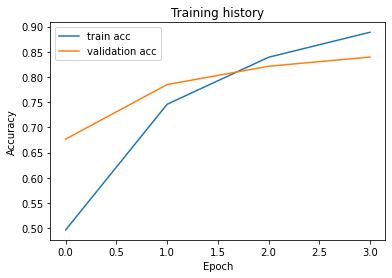

In [54]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


In [55]:
model.load_state_dict(torch.load('best_model.bin'))
test_acc,test_loss, _ = eval(model, test_dataloader, loss_fn,device, len(df_test))

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Test Loss: 0.566 | Test Acc: 84.01%


In [56]:
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor))
    out = F.softmax(prediction, 1)

    pred = torch.max(prediction, 1)[1].view(1).data
    if ((pred.item()) == 1):
        print ("Sentiment: Positive")
    else:
        print ("Sentiment: Negative")

predict_sentiment(model, "this movie is not good at all")

NameError: name 'nlp' is not defined